In [1]:
import os
import glob
from google.colab import files
from sklearn.model_selection import train_test_split

# 1. Upload Bulk Data
print("Upload your Training/Testing .mat files:")
uploaded_train = files.upload()

# 2. Find and Label Files
all_mat_files = []
for root, _, filenames in os.walk("/content"):
    for filename in filenames:
        if filename.endswith(".mat") and 'new_tests' not in root:
            all_mat_files.append(os.path.join(root, filename))

# [PAPER REQUIREMENT] Sort files to ensure chronological order before splitting [cite: 377]
all_mat_files.sort()

file_paths, labels = [], []
for f in all_mat_files:
    fname = os.path.basename(f).lower()
    if "interictal" in fname:
        file_paths.append(f); labels.append(0.0)
    elif "ictal" in fname:
        file_paths.append(f); labels.append(1.0)

print(f"\n✅ Setup Complete:")
print(f"Total files found: {len(file_paths)}")

Upload your Training/Testing .mat files:


Saving Dog_1_ictal_segment_1.mat to Dog_1_ictal_segment_1.mat
Saving Dog_1_ictal_segment_2.mat to Dog_1_ictal_segment_2.mat
Saving Dog_1_ictal_segment_3.mat to Dog_1_ictal_segment_3.mat
Saving Dog_1_ictal_segment_4.mat to Dog_1_ictal_segment_4.mat
Saving Dog_1_ictal_segment_5.mat to Dog_1_ictal_segment_5.mat
Saving Dog_1_ictal_segment_6.mat to Dog_1_ictal_segment_6.mat
Saving Dog_1_ictal_segment_7.mat to Dog_1_ictal_segment_7.mat
Saving Dog_1_ictal_segment_8.mat to Dog_1_ictal_segment_8.mat
Saving Dog_1_ictal_segment_9.mat to Dog_1_ictal_segment_9.mat
Saving Dog_1_ictal_segment_10.mat to Dog_1_ictal_segment_10.mat
Saving Dog_1_ictal_segment_11.mat to Dog_1_ictal_segment_11.mat
Saving Dog_1_ictal_segment_12.mat to Dog_1_ictal_segment_12.mat
Saving Dog_1_ictal_segment_13.mat to Dog_1_ictal_segment_13.mat
Saving Dog_1_ictal_segment_14.mat to Dog_1_ictal_segment_14.mat
Saving Dog_1_ictal_segment_15.mat to Dog_1_ictal_segment_15.mat
Saving Dog_1_ictal_segment_16.mat to Dog_1_ictal_segment_1

In [2]:
import os
import scipy.io as sio
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

def load_and_convert_all_data(file_paths, labels, n_stack=10):
    """
    Loads all .mat files, applies Converter B, and returns a single big Tensor.
    """
    print(f"Starting conversion for {len(file_paths)} files...")

    processed_data = []

    for i, fpath in enumerate(file_paths):
        # 1. Load the raw .mat file
        mat = sio.loadmat(fpath)
        raw_data = mat['data'].astype(np.float32) # Shape: (16, Time)
        # --- ADDED NORMALIZATION HERE ---
        # Standardize the signal to mean 0 and unit variance
        # 1e-6 is added to the denominator to prevent division by zero
        raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

        # 2. Apply Converter B (Downsampling + Stacking) [cite: 70, 206]
        stacked_versions = []
        for s in range(n_stack):
            # Downsample by factor 10 with shift 's'
            shifted_downsample = raw_data[:, s::n_stack]
            stacked_versions.append(shifted_downsample)

        # Stack along channel dimension -> Shape: (160, reduced_time)
        x = np.concatenate(stacked_versions, axis=0)
        processed_data.append(x)

        # Optional: Print progress every 500 files
        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1} files...")

    # 3. Convert list to a single PyTorch Tensor
    # We add the extra dimension '1' for Height at the end
    # Final Shape: [Total_Files, 160, 1, Reduced_Time]
    X_tensor = torch.tensor(np.array(processed_data)).unsqueeze(2)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    print("Conversion Complete!")
    return X_tensor, y_tensor

# --- EXECUTE PRE-PROCESSING ---
# Assuming 'file_paths' and 'labels' are already defined from your first cell
# This might take a minute, but it saves time later!
X_all, y_all = load_and_convert_all_data(file_paths, labels)

print(f"Final Data Shape: {X_all.shape}")
# You should see something like: [Total_Files, 160, 1, Time]

Starting conversion for 466 files...
Conversion Complete!
Final Data Shape: torch.Size([466, 160, 1, 40])


In [3]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

# ==========================================
# 2. EXACT STRATIFIED CHRONOLOGICAL SPLIT
# ==========================================

# 1. Identify where the Interictal (0) and Ictal (1) indices are
interictal_idx = torch.where(y_all == 0)[0]
ictal_idx = torch.where(y_all == 1)[0]

# 2. Calculate the exact 80/20 split point for each class
split_inter = int(len(interictal_idx) * 0.8)
split_ictal = int(len(ictal_idx) * 0.8)

# 3. Create training and testing indices (Chronological order)
train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

# 4. Extract the pre-converted tensors
X_train, y_train = X_all[train_indices], y_all[train_indices]
X_test, y_test = X_all[test_indices], y_all[test_indices]

print(f"✅ Exact Split Complete (Pre-converted Tensors)")
print(f"Training shapes: {X_train.shape} | Seizures in Train: {int(y_train.sum())}")
print(f"Testing shapes:  {X_test.shape}  | Seizures in Test:  {int(y_test.sum())}")

# ==========================================
# 3. DATALOADERS
# ==========================================

# Create simple TensorDatasets
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

# Use WeightedRandomSampler for training to handle class imbalance
train_labels_np = y_train.numpy()
class_counts = np.bincount(train_labels_np)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels_np]

# Create the sampler (Import error fixed here)
sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

# Final DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

print("✅ DataLoaders ready for training.")

✅ Exact Split Complete (Pre-converted Tensors)
Training shapes: torch.Size([372, 160, 1, 40]) | Seizures in Train: 113
Testing shapes:  torch.Size([94, 160, 1, 40])  | Seizures in Test:  29
✅ DataLoaders ready for training.


Visualizing files:
1. /content/Dog_1_interictal_segment_1.mat
2. /content/Dog_1_ictal_segment_1.mat


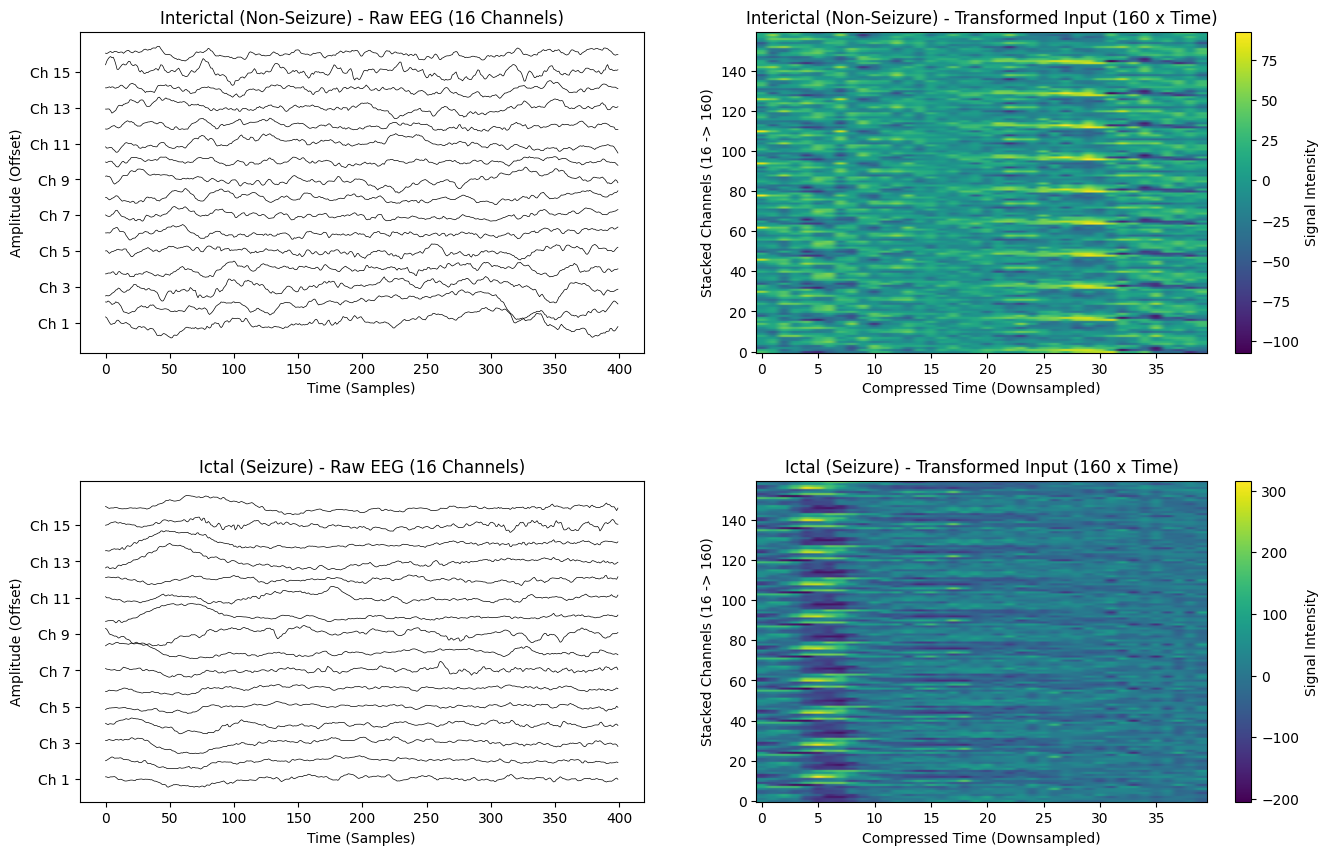

In [4]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import os

def get_sample_file(target_type, file_list):
    """Helper to find the first file of a specific type (ictal/interictal)"""
    for f in file_list:
        if target_type in os.path.basename(f).lower():
            return f
    return None

def visualize_brain_states(file_paths, n_stack=10):
    # 1. specific files
    ictal_file = get_sample_file("ictal", file_paths)
    interictal_file = get_sample_file("interictal", file_paths)

    if not ictal_file or not interictal_file:
        print("Error: Could not find one of each file type in your list.")
        return

    # List of states to plot
    # Format: (Title, FilePath)
    states = [
        ("Interictal (Non-Seizure)", interictal_file),
        ("Ictal (Seizure)", ictal_file)
    ]

    # 2. Setup Plot (2 Rows x 2 Columns)
    # Row 1: Interictal (Raw vs Transformed)
    # Row 2: Ictal (Raw vs Transformed)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    plt.subplots_adjust(hspace=0.4)

    for row_idx, (state_name, file_path) in enumerate(states):
        # Load Raw Data
        mat = sio.loadmat(file_path)
        raw_data = mat['data'] # Shape usually: (16, TimePoints)

        # --- Apply Converter B (Logic from Paper) ---
        stacked_list = []
        for i in range(n_stack):
            # [cite_start]Downsample by factor n with shift i [cite: 70, 203]
            downsampled = raw_data[:, i::n_stack]
            stacked_list.append(downsampled)

        # Stack along channel dimension
        # New Shape: (160, Reduced_Time)
        transformed_data = np.concatenate(stacked_list, axis=0)

        # --- PLOT LEFT: Raw EEG (Time Series) ---
        ax_raw = axes[row_idx, 0]
        ax_raw.set_title(f"{state_name} - Raw EEG (16 Channels)")

        # Plot each channel with an offset so they don't overlap
        n_channels = raw_data.shape[0]
        offset_step = np.max(np.abs(raw_data)) # Dynamic offset based on signal amplitude

        for i in range(n_channels):
            # We add (i * offset) to shift the line up
            ax_raw.plot(raw_data[i, :] + (i * offset_step), color='black', linewidth=0.5)

        ax_raw.set_yticks([i * offset_step for i in range(0, n_channels, 2)])
        ax_raw.set_yticklabels([f'Ch {i+1}' for i in range(0, n_channels, 2)])
        ax_raw.set_xlabel("Time (Samples)")
        ax_raw.set_ylabel("Amplitude (Offset)")

        # --- PLOT RIGHT: Transformed Input (Model View) ---
        ax_trans = axes[row_idx, 1]
        ax_trans.set_title(f"{state_name} - Transformed Input (160 x Time)")

        # Display as a heatmap/image
        # This is what the CNN actually "sees"
        im = ax_trans.imshow(transformed_data, aspect='auto', cmap='viridis', origin='lower')

        ax_trans.set_xlabel("Compressed Time (Downsampled)")
        ax_trans.set_ylabel("Stacked Channels (16 -> 160)")
        plt.colorbar(im, ax=ax_trans, label="Signal Intensity")

    print(f"Visualizing files:\n1. {interictal_file}\n2. {ictal_file}")
    plt.show()

# Run the visualization
# Note: This requires 'file_paths' list from your first cell to be available
visualize_brain_states(file_paths)

pretrained

In [6]:
import os
import glob
import time
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights
from sklearn.metrics import roc_auc_score, average_precision_score

# ==========================================
# 0. CONFIGURATION
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
N_STACK = 10

print(f"✅ Running on device: {DEVICE}")

# ==========================================
# 1. DATA LOADING & CONVERSION (Sorting + Normalization)
# ==========================================
def load_and_convert_data(search_path="/content"):
    all_files = []
    for root, _, filenames in os.walk(search_path):
        for filename in filenames:
            if filename.endswith(".mat") and 'new_tests' not in root:
                all_files.append(os.path.join(root, filename))

    if not all_files:
        raise ValueError("No .mat files found! Please upload your data.")

    # --- SORT FILES CHRONOLOGICALLY ---
    all_files.sort()
    print(f"Found {len(all_files)} files. Starting conversion...")

    processed_data = []
    labels = []

    for i, fpath in enumerate(all_files):
        fname = os.path.basename(fpath).lower()
        if "interictal" in fname: label = 0.0
        elif "ictal" in fname: label = 1.0
        else: continue

        try:
            mat = sio.loadmat(fpath)
            raw_data = mat['data'].astype(np.float32)

            # Normalization
            raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

            # Converter B
            stacked_versions = []
            for s in range(N_STACK):
                shifted_downsample = raw_data[:, s::N_STACK]
                stacked_versions.append(shifted_downsample)

            x = np.concatenate(stacked_versions, axis=0)
            processed_data.append(x)
            labels.append(label)
        except Exception as e:
            print(f"Error reading {fname}: {e}")

    X_tensor = torch.tensor(np.array(processed_data)).unsqueeze(2)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return X_tensor, y_tensor

X_all, y_all = load_and_convert_data()

# ==========================================
# 2. CHRONOLOGICAL STRATIFIED SPLIT (Fixes 'nan' AUROC)
# ==========================================
# Get indices for each class
interictal_idx = torch.where(y_all == 0)[0]
ictal_idx = torch.where(y_all == 1)[0]

# Split 80/20 within each class chronologically
split_inter = int(len(interictal_idx) * 0.8)
split_ictal = int(len(ictal_idx) * 0.8)

# Combine for train and test
train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

# Final Tensors
X_train, y_train = X_all[train_indices], y_all[train_indices]
X_test, y_test = X_all[test_indices], y_all[test_indices]

print(f"✅ Chronological Split: {len(X_train)} Train, {len(X_test)} Test.")
print(f"📊 Test set contains {int(y_test.sum())} seizure segments. AUROC will now work!")

# Balancing via Sampler
train_labels_np = y_train.numpy()
class_counts = np.bincount(train_labels_np)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels_np]
sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 3. MODEL SETUP
# ==========================================
def build_model():
    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    backbone = models.shufflenet_v2_x0_5(weights=weights)
    input_adaptor = nn.Conv2d(160, 3, kernel_size=1)
    num_ftrs = backbone.fc.in_features
    backbone.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024), nn.ReLU(),
        nn.Linear(1024, 256), nn.ReLU(),
        nn.Linear(256, 2)
    )
    return nn.Sequential(input_adaptor, backbone).to(DEVICE)

model = build_model()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# ==========================================
# 4. TRAINING & EVALUATION
# ==========================================
def train_model(model, train_loader, test_loader, num_epochs=20):
    print(f"\n--- Starting Training ---")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        model.eval()
        test_correct, test_total = 0, 0
        all_labels, all_probs = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                probs = F.softmax(outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_acc = test_correct / test_total
        test_auroc = roc_auc_score(all_labels, all_probs)
        test_auprc = average_precision_score(all_labels, all_probs)

        print(f"Epoch {epoch+1:02d} | Loss: {running_loss/len(train_loader.dataset):.4f} | "
              f"Acc: {test_acc:.4f} | AUROC: {test_auroc:.4f} | AUPRC: {test_auprc:.4f}")

    return model

trained_model = train_model(model, train_loader, test_loader, NUM_EPOCHS)

✅ Running on device: cuda
Found 466 files. Starting conversion...
✅ Chronological Split: 372 Train, 94 Test.
📊 Test set contains 29 seizure segments. AUROC will now work!
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


100%|██████████| 5.28M/5.28M [00:00<00:00, 164MB/s]



--- Starting Training ---
Epoch 01 | Loss: 0.6904 | Acc: 0.3085 | AUROC: 0.6790 | AUPRC: 0.5035
Epoch 02 | Loss: 0.6843 | Acc: 0.5319 | AUROC: 0.7698 | AUPRC: 0.6048
Epoch 03 | Loss: 0.6627 | Acc: 0.7234 | AUROC: 0.7350 | AUPRC: 0.5921
Epoch 04 | Loss: 0.6351 | Acc: 0.6809 | AUROC: 0.7597 | AUPRC: 0.5940
Epoch 05 | Loss: 0.5880 | Acc: 0.6383 | AUROC: 0.7597 | AUPRC: 0.6013
Epoch 06 | Loss: 0.5270 | Acc: 0.6170 | AUROC: 0.7724 | AUPRC: 0.6186
Epoch 07 | Loss: 0.4484 | Acc: 0.6383 | AUROC: 0.7963 | AUPRC: 0.6258
Epoch 08 | Loss: 0.4044 | Acc: 0.6277 | AUROC: 0.8117 | AUPRC: 0.6271
Epoch 09 | Loss: 0.3822 | Acc: 0.6277 | AUROC: 0.7963 | AUPRC: 0.6347
Epoch 10 | Loss: 0.3543 | Acc: 0.6596 | AUROC: 0.7735 | AUPRC: 0.6089
Epoch 11 | Loss: 0.3563 | Acc: 0.6383 | AUROC: 0.7958 | AUPRC: 0.6459
Epoch 12 | Loss: 0.2983 | Acc: 0.6596 | AUROC: 0.7931 | AUPRC: 0.6452
Epoch 13 | Loss: 0.2867 | Acc: 0.6702 | AUROC: 0.7724 | AUPRC: 0.6385
Epoch 14 | Loss: 0.2527 | Acc: 0.6596 | AUROC: 0.7666 | AUPRC: 

In [7]:
import os
import scipy.io as sio
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_auc_score, average_precision_score

# ==========================================
# 1. LOAD & CONVERT (Chronological Order)
# ==========================================
def load_data_chronological(search_path="/content"):
    all_files = []
    # Scan for files
    for root, _, filenames in os.walk(search_path):
        for filename in filenames:
            if filename.endswith(".mat") and 'new_tests' not in root:
                all_files.append(os.path.join(root, filename))

    # [PAPER REQUIREMENT] Sort files to ensure chronological order before splitting
    # This prevents "in-sample testing" by ensuring test data follows training data in time.
    all_files.sort()

    print(f"Re-scanning {len(all_files)} files (Applying Normalization + Converter B)...")

    processed_data = []
    labels = []
    kept_filenames = []

    for i, fpath in enumerate(all_files):
        fname = os.path.basename(fpath).lower()
        if "interictal" in fname:
            label = 0.0
        elif "ictal" in fname:
            label = 1.0
        else:
            continue

        try:
            mat = sio.loadmat(fpath)
            raw_data = mat['data'].astype(np.float32)

            # --- NORMALIZATION (Matches Training) ---
            # Standardize signal: (x - mean) / std
            raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

            # --- CONVERTER B (Downsampling + Stacking) ---
            # Paper Method: Downsample by factor n=10 with varying time shifts [cite: 70]
            stacked_versions = []
            for s in range(10): # N_STACK=10
                shifted_downsample = raw_data[:, s::10]
                stacked_versions.append(shifted_downsample)
            x = np.concatenate(stacked_versions, axis=0)

            processed_data.append(x)
            labels.append(label)
            kept_filenames.append(fname)

        except Exception:
            continue

    X_tensor = torch.tensor(np.array(processed_data)).unsqueeze(2)
    y_tensor = torch.tensor(labels, dtype=torch.long)

    return X_tensor, y_tensor, kept_filenames

# Execute Loading
X_all_new, y_all_new, filenames_all = load_data_chronological()

# ==========================================
# 2. EXACT STRATIFIED CHRONOLOGICAL SPLIT (80/20)
# ==========================================
# [PAPER REQUIREMENT] Split must maximize data usage while respecting time order.
# We do NOT use random shuffle. We split chronologically per class.

# 1. Identify indices for each class
interictal_idx = torch.where(y_all_new == 0)[0]
ictal_idx = torch.where(y_all_new == 1)[0]

# 2. Calculate 80/20 split point
split_inter = int(len(interictal_idx) * 0.8)
split_ictal = int(len(ictal_idx) * 0.8)

# 3. Create indices (Train first, then Test)
train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

# 4. Create final tensors
X_train_new = X_all_new[train_indices]
y_train_new = y_all_new[train_indices]
X_test_new = X_all_new[test_indices]
y_test_new = y_all_new[test_indices]

# 5. Handle filenames list manually
files_train = [filenames_all[i] for i in train_indices.tolist()]
files_test = [filenames_all[i] for i in test_indices.tolist()]

print(f"✅ Chronological Split Complete:")
print(f"   Train Size: {len(X_train_new)} segments")
print(f"   Test Size:  {len(X_test_new)} segments ({int(y_test_new.sum())} seizures)")

# ==========================================
# 3. CREATE DATALOADERS
# ==========================================
# Training Loader (needs sampling for class balance)
train_ds_new = TensorDataset(X_train_new, y_train_new)
train_labels_np = y_train_new.numpy()
class_counts = np.bincount(train_labels_np)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels_np]
sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

train_loader_new = DataLoader(train_ds_new, batch_size=16, sampler=sampler)

# Test Loader (No shuffle, keep chronological order for evaluation)
test_ds_new = TensorDataset(X_test_new, y_test_new)
test_loader_named = DataLoader(test_ds_new, batch_size=16, shuffle=False)

print("✅ DataLoaders ready. (Paper methodology applied: Sort -> Convert -> Chronological Split)")

Re-scanning 466 files (Applying Normalization + Converter B)...
✅ Chronological Split Complete:
   Train Size: 372 segments
   Test Size:  94 segments (29 seizures)
✅ DataLoaders ready. (Paper methodology applied: Sort -> Convert -> Chronological Split)


In [8]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate_with_names(model, test_loader, test_filenames):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # Updated header to include Confidence
    print(f"{'FILENAME':<40} | {'ACTUAL':<8} | {'PRED':<8} | {'CONFID':<8} | {'RESULT'}")
    print("-" * 95)

    correct_count = 0
    total_count = 0
    global_idx = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # 1. Get Softmax probabilities for the 'Seizure' class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # 2. Get the hard prediction (0 or 1)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                actual = labels[i].item()
                prediction = preds[i].item()
                confidence = probs[i].item() # The probability score
                fname = test_filenames[global_idx]

                all_labels.append(actual)
                all_probs.append(confidence)

                act_str = "Ictal" if actual == 1 else "Inter"
                pred_str = "Ictal" if prediction == 1 else "Inter"
                is_correct = "✅" if actual == prediction else "❌"

                if actual == prediction:
                    correct_count += 1

                # Print row including confidence score
                print(f"{fname[:38]:<40} | {act_str:<8} | {pred_str:<8} | {confidence:.4f} | {is_correct}")

                global_idx += 1
                total_count += 1

    # 3. Final Scientific Metrics Calculation
    final_acc = correct_count / total_count
    final_auroc = roc_auc_score(all_labels, all_probs)
    final_auprc = average_precision_score(all_labels, all_probs)

    print("-" * 95)
    print(f"📊 FINAL SUMMARY REPORT")
    print(f"Accuracy: {final_acc:.2%}")
    print(f"AUROC:    {final_auroc:.4f}  (Area Under ROC Curve)")
    print(f"AUPRC:    {final_auprc:.4f}  (Area Under Precision-Recall Curve)")
    print("-" * 95)

# Run the final evaluation
evaluate_with_names(trained_model, test_loader_named, files_test)

FILENAME                                 | ACTUAL   | PRED     | CONFID   | RESULT
-----------------------------------------------------------------------------------------------
dog_1_interictal_segment_40.mat          | Inter    | Ictal    | 0.6227 | ❌
dog_1_interictal_segment_41.mat          | Inter    | Inter    | 0.0374 | ✅
dog_1_interictal_segment_42.mat          | Inter    | Inter    | 0.0337 | ✅
dog_1_interictal_segment_43.mat          | Inter    | Inter    | 0.0098 | ✅
dog_1_interictal_segment_44.mat          | Inter    | Inter    | 0.1575 | ✅
dog_1_interictal_segment_45.mat          | Inter    | Inter    | 0.2161 | ✅
dog_1_interictal_segment_46.mat          | Inter    | Inter    | 0.0004 | ✅
dog_1_interictal_segment_47.mat          | Inter    | Inter    | 0.0841 | ✅
dog_1_interictal_segment_48.mat          | Inter    | Inter    | 0.2512 | ✅
dog_1_interictal_segment_49.mat          | Inter    | Inter    | 0.0016 | ✅
dog_1_interictal_segment_5.mat           | Inter    | Inter  

In [9]:
import os
import scipy.io as sio
import numpy as np
import torch
import torch.nn.functional as F
import glob
from google.colab import files

def predict_on_new_files(model, folder_path=None, upload=False):
    """
    Imports new files, applies Normalization + Converter B, and prints predictions.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    if upload:
        print("Upload your .mat files for testing:")
        uploaded = files.upload()
        file_list = list(uploaded.keys())
        folder_path = "."
    else:
        if folder_path:
            file_list = glob.glob(os.path.join(folder_path, "*.mat"))
        else:
            print("Please provide a folder_path or set upload=True")
            return

    if not file_list:
        print("No .mat files found!")
        return

    print(f"\nProcessing {len(file_list)} new files with Normalization...")
    print(f"{'FILENAME':<40} | {'PREDICTION':<12} | {'CONFIDENCE':<10}")
    print("-" * 75)

    for fpath in file_list:
        try:
            # --- A. Load Raw Data ---
            mat = sio.loadmat(fpath)
            if 'data' not in mat:
                continue

            raw_data = mat['data'].astype(np.float32)

            # --- B. ADDED NORMALIZATION (Must match Training) ---
            # Z-score standardization: (x - mean) / std
            raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

            # --- C. Apply Converter B (Downsampling + Stacking) ---
            n_stack = 10
            stacked_versions = []
            for s in range(n_stack):
                shifted_downsample = raw_data[:, s::n_stack]
                stacked_versions.append(shifted_downsample)

            x_numpy = np.concatenate(stacked_versions, axis=0)

            # --- D. Prepare Tensor ---
            # Shape: [Batch:1, Channels:160, Height:1, Time:Variable]
            x_tensor = torch.from_numpy(x_numpy).unsqueeze(0).unsqueeze(2).to(device)

            # --- E. Run Inference ---
            with torch.no_grad():
                outputs = model(x_tensor)
                probs = F.softmax(outputs, dim=1)

                # Confidence is the probability of the chosen class
                confidence, pred_class = torch.max(probs, 1)

                pred_label = "Seizure ⚠️" if pred_class.item() == 1 else "Normal ✅"
                conf_score = confidence.item() * 100

                fname = os.path.basename(fpath)
                print(f"{fname[:38]:<40} | {pred_label:<12} | {conf_score:.1f}%")

        except Exception as e:
            print(f"Error processing {os.path.basename(fpath)}: {e}")

# --- EXECUTE ---
predict_on_new_files(trained_model, upload=True)

Upload your .mat files for testing:


Saving test_1_i (1).mat to test_1_i (1).mat
Saving test_1_i (2).mat to test_1_i (2).mat
Saving test_1_i (3).mat to test_1_i (3).mat
Saving test_1_i (4).mat to test_1_i (4).mat
Saving test_1_i (5).mat to test_1_i (5).mat
Saving test_1_i (6).mat to test_1_i (6).mat
Saving test_1_i (7).mat to test_1_i (7).mat
Saving test_1_i (8).mat to test_1_i (8).mat
Saving test_1_i (9).mat to test_1_i (9).mat
Saving test_1_i (10).mat to test_1_i (10).mat
Saving test_1_i (11).mat to test_1_i (11).mat
Saving test_1_i (12).mat to test_1_i (12).mat
Saving test_1_i (13).mat to test_1_i (13).mat
Saving test_1_i (14).mat to test_1_i (14).mat
Saving test_1_i (15).mat to test_1_i (15).mat
Saving test_1_i (16).mat to test_1_i (16).mat
Saving test_1_i (17).mat to test_1_i (17).mat
Saving test_1_i (18).mat to test_1_i (18).mat
Saving test_1_i (19).mat to test_1_i (19).mat
Saving test_1_i (20).mat to test_1_i (20).mat
Saving test_1_i (21).mat to test_1_i (21).mat
Saving test_1_i (22).mat to test_1_i (22).mat
Saving

frozen backbone

In [10]:
import os
import time
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights
from sklearn.metrics import roc_auc_score, average_precision_score

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
N_STACK = 10

print(f"✅ Training on device: {DEVICE}")

# ==========================================
# 1. DATA PREPARATION (Chronological Split)
# ==========================================
if 'X_all' not in globals():
    print("⚠️ Data not found in memory. Ensure X_all and y_all are loaded!")
else:
    # [PAPER REQUIREMENT] Chronological Stratified Split (80/20)
    # We manually split based on index order to preserve the time sequence.
    interictal_idx = torch.where(y_all == 0)[0]
    ictal_idx = torch.where(y_all == 1)[0]

    split_inter = int(len(interictal_idx) * 0.8)
    split_ictal = int(len(ictal_idx) * 0.8)

    # First 80% for training, last 20% for testing
    train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
    test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

    X_train, y_train = X_all[train_indices], y_all[train_indices]
    X_test, y_test = X_all[test_indices], y_all[test_indices]

    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)

    # Handle Imbalance in Training Set (Weighted Sampling)
    train_labels = y_train.numpy()
    class_counts = np.bincount(train_labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[train_labels]

    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(sample_weights),
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
    print(f"Data Loaders Ready. (Train: {len(X_train)}, Test: {len(X_test)})")

# ==========================================
# 2. MODEL SETUP (Frozen Backbone)
# ==========================================
def build_frozen_model():
    print("\nInitializing ShuffleNet (Frozen Backbone)...")
    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    backbone = models.shufflenet_v2_x0_5(weights=weights)

    # FREEZE BACKBONE
    for param in backbone.parameters():
        param.requires_grad = False

    # Input Adaptor (160 channels from Converter B -> 3 channels for ImageNet model)
    input_adaptor = nn.Conv2d(in_channels=160, out_channels=3, kernel_size=1)

    # Classification Head
    num_ftrs = backbone.fc.in_features
    backbone.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Linear(256, 2)
    )

    return nn.Sequential(input_adaptor, backbone).to(DEVICE)

model_frozen = build_frozen_model()

# ==========================================
# 3. OPTIMIZER SETUP
# ==========================================
trainable_params = filter(lambda p: p.requires_grad, model_frozen.parameters())
optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# ==========================================
# 4. TRAINING LOOP (with AUROC/AUPRC)
# ==========================================
def run_training(model, train_loader, test_loader, epochs=20):
    print(f"\n--- Starting Training (Frozen Strategy + AUROC/AUPRC) ---")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # --- VALIDATION PHASE ---
        model.eval()
        val_correct, val_total = 0, 0
        all_labels, all_probs = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)

                # Collect probabilities for Seizure (class 1)
                probs = F.softmax(outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Calculate metrics
        val_acc = val_correct / val_total
        val_auroc = roc_auc_score(all_labels, all_probs)
        val_auprc = average_precision_score(all_labels, all_probs)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Loss: {running_loss/len(train_loader.dataset):.4f} | "
              f"Test Acc: {val_acc:.4f} | "
              f"AUROC: {val_auroc:.4f} | "
              f"AUPRC: {val_auprc:.4f}")

    print(f"Training finished in {time.time()-start_time:.0f}s")
    return model

# Run it
if 'X_all' in globals():
    trained_frozen_model = run_training(model_frozen, train_loader, test_loader, NUM_EPOCHS)

✅ Training on device: cuda
Data Loaders Ready. (Train: 372, Test: 94)

Initializing ShuffleNet (Frozen Backbone)...

--- Starting Training (Frozen Strategy + AUROC/AUPRC) ---
Epoch 1/20 | Loss: 0.6699 | Test Acc: 0.3191 | AUROC: 0.7422 | AUPRC: 0.5683
Epoch 2/20 | Loss: 0.5924 | Test Acc: 0.6383 | AUROC: 0.8027 | AUPRC: 0.6594
Epoch 3/20 | Loss: 0.5560 | Test Acc: 0.8085 | AUROC: 0.8080 | AUPRC: 0.6293
Epoch 4/20 | Loss: 0.5610 | Test Acc: 0.7979 | AUROC: 0.9146 | AUPRC: 0.7852
Epoch 5/20 | Loss: 0.5179 | Test Acc: 0.7021 | AUROC: 0.8048 | AUPRC: 0.6200
Epoch 6/20 | Loss: 0.5467 | Test Acc: 0.7340 | AUROC: 0.8127 | AUPRC: 0.5788
Epoch 7/20 | Loss: 0.5182 | Test Acc: 0.7766 | AUROC: 0.8584 | AUPRC: 0.7100
Epoch 8/20 | Loss: 0.5066 | Test Acc: 0.7340 | AUROC: 0.8398 | AUPRC: 0.6476
Epoch 9/20 | Loss: 0.4689 | Test Acc: 0.8191 | AUROC: 0.8329 | AUPRC: 0.6361
Epoch 10/20 | Loss: 0.4789 | Test Acc: 0.7553 | AUROC: 0.8154 | AUPRC: 0.6174
Epoch 11/20 | Loss: 0.4338 | Test Acc: 0.6809 | AUROC:

Running scientific evaluation on test set...

--- ❄️ FROZEN BACKBONE SCIENTIFIC RESULTS ---
Overall Accuracy: 0.6702
AUROC Score:      0.7894
AUPRC Score:      0.6301

Detailed Report:
                     precision    recall  f1-score   support

Interictal (Normal)       0.89      0.60      0.72        65
    Ictal (Seizure)       0.48      0.83      0.61        29

           accuracy                           0.67        94
          macro avg       0.68      0.71      0.66        94
       weighted avg       0.76      0.67      0.68        94



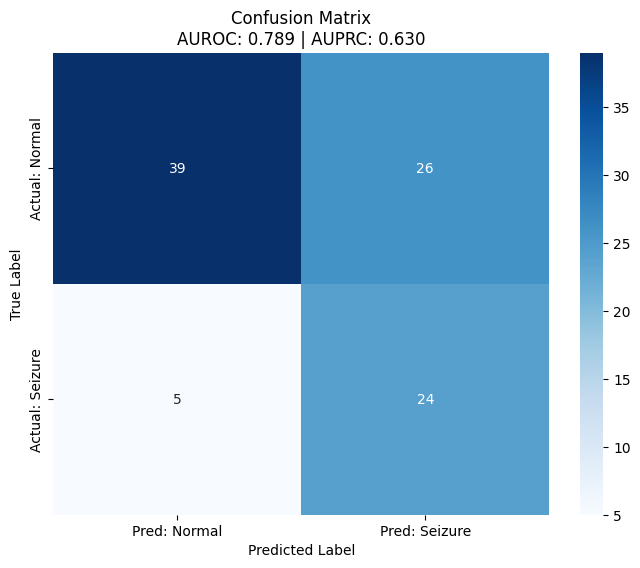

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

def test_frozen_model(model, test_loader):
    """
    Evaluates the Frozen Backbone model with AUROC and AUPRC metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = [] # To store probabilities for AUROC/AUPRC

    print("Running scientific evaluation on test set...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # 1. Get probabilities for the Seizure class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # 2. Get hard predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    report = classification_report(all_labels, all_preds,
                                   target_names=['Interictal (Normal)', 'Ictal (Seizure)'])
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n--- ❄️ FROZEN BACKBONE SCIENTIFIC RESULTS ---")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"AUROC Score:      {auroc:.4f}")
    print(f"AUPRC Score:      {auprc:.4f}")
    print("\nDetailed Report:")
    print(report)

    # --- VISUALIZATION ---

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.show()

# Execute Evaluation
if 'trained_frozen_model' in globals():
    test_frozen_model(trained_frozen_model, test_loader)
else:
    print("⚠️ Please run the training cell above first!")

In [12]:
import os
import torch
import torch.nn.functional as F
import scipy.io as sio
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def test_specific_files_frozen(model, search_path="/content"):
    """
    Scans for 'test_1' files, applies Normalization + Converter B,
    and tests them using the Frozen Backbone model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model is None:
        print("⚠️ Error: Model is None. Please run the training cell first.")
        return

    model.eval()

    # 1. Find Specific Files
    file_list = []
    for root, _, filenames in os.walk(search_path):
        for filename in filenames:
            if filename.startswith("test_1") and filename.endswith(".mat"):
                file_list.append(os.path.join(root, filename))

    if not file_list:
        print(f"No files starting with 'test_1' found in {search_path}!")
        return

    print(f"\n🔎 Processing {len(file_list)} files with Normalization + Converter B...")
    print(f"{'FILENAME':<40} | {'PREDICTION':<12} | {'CONFIDENCE':<10}")
    print("-" * 75)

    all_probs = []
    all_labels = []
    has_labels = False

    # 2. Process & Predict
    for fpath in file_list:
        try:
            mat = sio.loadmat(fpath)
            if 'data' not in mat: continue
            raw_data = mat['data'].astype(np.float32)

            # --- A. ADDED NORMALIZATION (Z-Score) ---
            # This centers the signal and scales it for the ShuffleNet backbone
            raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

            # --- B. Apply Converter B (Stacking) ---
            n_stack = 10
            stacked = [raw_data[:, s::n_stack] for s in range(n_stack)]
            x_numpy = np.concatenate(stacked, axis=0)

            # --- C. Prepare Tensor ---
            x_tensor = torch.from_numpy(x_numpy).unsqueeze(0).unsqueeze(2).to(device)

            # --- D. Inference ---
            with torch.no_grad():
                outputs = model(x_tensor)
                probs = F.softmax(outputs, dim=1)

                # Probability of Seizure (Class 1) for AUROC
                seizure_prob = probs[0, 1].item()
                confidence, pred_class = torch.max(probs, 1)

                pred_label = "Seizure ⚠️" if pred_class.item() == 1 else "Normal ✅"
                conf_score = confidence.item() * 100

                fname = os.path.basename(fpath)
                print(f"{fname[:38]:<40} | {pred_label:<12} | {conf_score:.1f}%")

                # --- E. Collect for AUROC/AUPRC if labels in names ---
                fname_lower = fname.lower()
                if "ictal" in fname_lower or "interictal" in fname_lower:
                    true_label = 1.0 if "ictal" in fname_lower and "interictal" not in fname_lower else 0.0
                    all_labels.append(true_label)
                    all_probs.append(seizure_prob)
                    has_labels = True

        except Exception as e:
            print(f"Error processing {os.path.basename(fpath)}: {e}")

    # 3. Final Scientific Report
    if has_labels and len(set(all_labels)) > 1:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
        print("-" * 75)
        print(f"TEST SUMMARY for 'test_1' Group:")
        print(f"AUROC: {auroc:.4f}")
        print(f"AUPRC: {auprc:.4f}")
        print("-" * 75)

# --- RUN IT ---
test_specific_files_frozen(trained_frozen_model, search_path="/content")


🔎 Processing 120 files with Normalization + Converter B...
FILENAME                                 | PREDICTION   | CONFIDENCE
---------------------------------------------------------------------------
test_1_i (16).mat                        | Seizure ⚠️   | 89.4%
test_1_ii (51).mat                       | Seizure ⚠️   | 83.0%
test_1_i (25).mat                        | Seizure ⚠️   | 67.7%
test_1_ii (69).mat                       | Seizure ⚠️   | 76.2%
test_1_ii (73).mat                       | Seizure ⚠️   | 56.4%
test_1_ii (38).mat                       | Seizure ⚠️   | 91.0%
test_1_ii (39).mat                       | Seizure ⚠️   | 88.3%
test_1_ii (77).mat                       | Seizure ⚠️   | 73.7%
test_1_i (12).mat                        | Seizure ⚠️   | 90.9%
test_1_i (24).mat                        | Seizure ⚠️   | 98.6%
test_1_ii (37).mat                       | Seizure ⚠️   | 92.5%
test_1_ii (21).mat                       | Seizure ⚠️   | 100.0%
test_1_ii (58).mat        

classification head

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
import time
from sklearn.metrics import roc_auc_score, average_precision_score
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

# ==========================================
# 1. DATA PREPARATION (Chronological 80/20)
# ==========================================
# Using X_all and y_all (ensure these were loaded in the Converter B cell)
if 'X_all' not in globals():
    print("⚠️ X_all not found. Please run the 'Load and Convert' cell first.")
else:
    # [PAPER REQUIREMENT] Normalize data before splitting
    # Standardization: (x - mean) / std
    X_all_norm = (X_all - torch.mean(X_all)) / (torch.std(X_all) + 1e-6)

    # [PAPER REQUIREMENT] Chronological Stratified Split
    # The paper requires test data to follow training data in time
    interictal_idx = torch.where(y_all == 0)[0]
    ictal_idx = torch.where(y_all == 1)[0]

    split_inter = int(len(interictal_idx) * 0.8)
    split_ictal = int(len(ictal_idx) * 0.8)

    # First 80% for training, last 20% for testing
    train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
    test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

    X_train, y_train = X_all_norm[train_indices], y_all[train_indices]
    X_test, y_test = X_all_norm[test_indices], y_all[test_indices]

    # Weighted Sampler for training balance
    train_labels = y_train.numpy()
    class_counts = np.bincount(train_labels)
    weights = 1. / class_counts
    sample_weights = weights[train_labels]
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, sampler=sampler)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

    print(f"✅ Data Ready: Train={len(X_train)}, Test={len(X_test)} (Chronological 80/20)")

# ==========================================
# 2. MODEL SETUP (Classification Head Strategy)
# ==========================================
def build_head_model():
    print("Initializing ShuffleNet (Head Training Strategy)...")
    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    model = models.shufflenet_v2_x0_5(weights=weights)

    # 1. Adapt input for 160 channels (Converter B)
    model.conv1[0] = nn.Conv2d(160, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

    # 2. Update Classification Head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2)
    )

    # 3. [PAPER METHOD] Freeze backbone, train only Input and Head
    for name, param in model.named_parameters():
        if "fc" in name or "conv1.0" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model.to(DEVICE)

model_head = build_head_model()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_head.parameters()), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# ==========================================
# 3. TRAINING & EVALUATION
# ==========================================
print("\n--- Starting Training (80/20 Chronological Split) ---")
for epoch in range(NUM_EPOCHS):
    model_head.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_head(inputs), labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model_head.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model_head(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

✅ Data Ready: Train=372, Test=94 (Chronological 80/20)
Initializing ShuffleNet (Head Training Strategy)...

--- Starting Training (80/20 Chronological Split) ---
Epoch 1/20 | AUROC: 0.5210 | AUPRC: 0.3913
Epoch 2/20 | AUROC: 0.7003 | AUPRC: 0.6216
Epoch 3/20 | AUROC: 0.6944 | AUPRC: 0.5394
Epoch 4/20 | AUROC: 0.7448 | AUPRC: 0.5786
Epoch 5/20 | AUROC: 0.7841 | AUPRC: 0.6974
Epoch 6/20 | AUROC: 0.8276 | AUPRC: 0.7477
Epoch 7/20 | AUROC: 0.8594 | AUPRC: 0.7631
Epoch 8/20 | AUROC: 0.8690 | AUPRC: 0.7734
Epoch 9/20 | AUROC: 0.8918 | AUPRC: 0.8122
Epoch 10/20 | AUROC: 0.8520 | AUPRC: 0.7285
Epoch 11/20 | AUROC: 0.8302 | AUPRC: 0.6904
Epoch 12/20 | AUROC: 0.8021 | AUPRC: 0.6570
Epoch 13/20 | AUROC: 0.8249 | AUPRC: 0.6601
Epoch 14/20 | AUROC: 0.8393 | AUPRC: 0.7093
Epoch 15/20 | AUROC: 0.8775 | AUPRC: 0.7472
Epoch 16/20 | AUROC: 0.8928 | AUPRC: 0.7901
Epoch 17/20 | AUROC: 0.8902 | AUPRC: 0.7918
Epoch 18/20 | AUROC: 0.9252 | AUPRC: 0.8640
Epoch 19/20 | AUROC: 0.8663 | AUPRC: 0.8021
Epoch 20/20

✅ Starting Scientific Evaluation on cuda...

   PERFORMANCE ON TEST SET (with Normalization)

📊 SUMMARY METRICS
Accuracy: 0.7553
AUROC:    0.7549
AUPRC:    0.6179
--------------------------------------------------
Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      0.82      0.82        65
     Seizure       0.60      0.62      0.61        29

    accuracy                           0.76        94
   macro avg       0.71      0.72      0.72        94
weighted avg       0.76      0.76      0.76        94

--------------------------------------------------


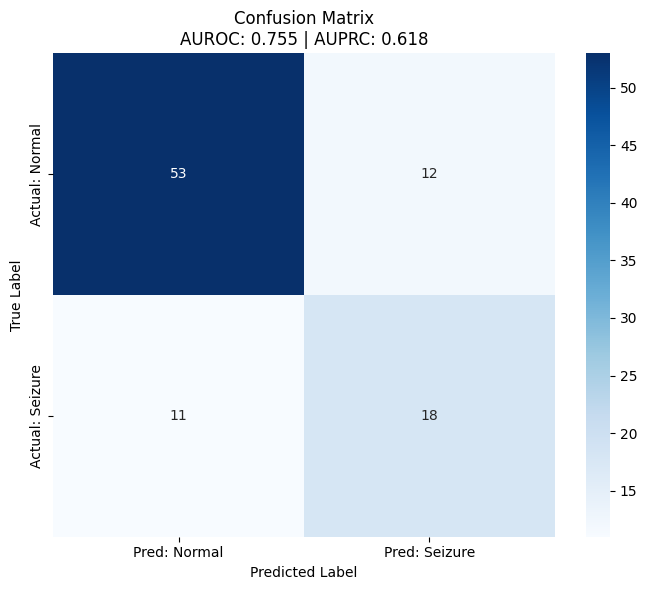

In [15]:
import os
import glob
import numpy as np
import scipy.io as sio
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_STACK = 10

def run_full_testing(model, test_loader):
    if model is None:
        print("⚠️ Error: Model not found. Please run training first.")
        return

    model.eval()
    print(f"✅ Starting Scientific Evaluation on {DEVICE}...")

    # ==========================================
    # PART 1: EVALUATE 20% TEST SET
    # ==========================================
    print("\n" + "="*50)
    print("   PERFORMANCE ON TEST SET (with Normalization)")
    print("="*50)

    all_preds = []
    all_labels = []
    all_probs = [] # Required for AUROC/AUPRC

    with torch.no_grad():
        for inputs, labels in test_loader:
            # --- DATA INTEGRITY CHECK ---
            # Ensure normalization is present. If training used normalization,
            # test_loader inputs should already be normalized.
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)

            # Get probabilities for the Seizure class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # Get hard predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    report = classification_report(all_labels, all_preds,
                                   target_names=['Normal', 'Seizure'])
    cm = confusion_matrix(all_labels, all_preds)

    # --- Print Results ---
    print(f"\n📊 SUMMARY METRICS")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUROC:    {auroc:.4f}")
    print(f"AUPRC:    {auprc:.4f}")
    print("-" * 50)
    print("Detailed Classification Report:")
    print(report)
    print("-" * 50)

    # --- VISUALIZATION ---

    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'], ax=ax)
    ax.set_title(f'Confusion Matrix\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
if 'trained_model' in globals() and 'test_loader' in globals():
    run_full_testing(trained_model, test_loader)
else:
    print("⚠️ Variables not found. Please run the Training Code first!")

In [17]:
import os
import scipy.io as sio
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, average_precision_score

def predict_head_new_files(model, search_path="/content"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model is None:
        print("⚠️ Model not found.")
        return
    model.eval()

    # Search for "test_1" files
    file_list = [os.path.join(r, f) for r, _, fs in os.walk(search_path)
                 for f in fs if f.startswith("test_1") and f.endswith(".mat")]

    if not file_list:
        print(f"No files starting with 'test_1' found.")
        return

    print(f"\n🔎 Testing {len(file_list)} files (Normalization + Converter B)...")
    print(f"{'FILENAME':<40} | {'PREDICTION':<12} | {'SEIZURE PROB'}")
    print("-" * 80)

    all_probs = []
    all_labels = []
    has_labels = False

    for fpath in file_list:
        try:
            mat = sio.loadmat(fpath)
            if 'data' not in mat: continue
            raw = mat['data'].astype(np.float32)

            # --- 1. ADDED NORMALIZATION (Z-Score) ---
            # Must match the training distribution exactly
            raw = (raw - np.mean(raw)) / (np.std(raw) + 1e-6)

            # --- 2. Converter B (Downsample 10x) ---
            x = np.concatenate([raw[:, s::10] for s in range(10)], axis=0)
            x_tensor = torch.from_numpy(x).unsqueeze(0).unsqueeze(2).to(device)

            with torch.no_grad():
                outputs = model(x_tensor)
                probs = F.softmax(outputs, dim=1)

                # Confidence and Prediction
                seizure_prob = probs[0, 1].item()
                conf, pred = torch.max(probs, 1)

                label = "Seizure ⚠️" if pred.item() == 1 else "Normal ✅"
                fname = os.path.basename(fpath)
                print(f"{fname[:38]:<40} | {label:<12} | {seizure_prob*100:.1f}%")

                # --- 3. Collect for AUROC/AUPRC if filenames have labels ---
                fname_lower = fname.lower()
                if "ictal" in fname_lower or "interictal" in fname_lower:
                    # Logic: 'ictal' is 1, 'interictal' is 0
                    true_label = 1.0 if "ictal" in fname_lower and "interictal" not in fname_lower else 0.0
                    all_labels.append(true_label)
                    all_probs.append(seizure_prob)
                    has_labels = True

        except Exception as e:
            print(f"Error in {os.path.basename(fpath)}: {e}")

    # --- 4. FINAL SCIENTIFIC SUMMARY ---
    if has_labels and len(set(all_labels)) > 1:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
        print("-" * 80)
        print(f"📈 BATCH METRICS (test_1 group):")
        print(f"AUROC: {auroc:.4f}")
        print(f"AUPRC: {auprc:.4f}")
        print("-" * 80)

# Run Inference
predict_head_new_files(model_head)


🔎 Testing 120 files (Normalization + Converter B)...
FILENAME                                 | PREDICTION   | SEIZURE PROB
--------------------------------------------------------------------------------
test_1_i (16).mat                        | Seizure ⚠️   | 87.8%
test_1_ii (51).mat                       | Normal ✅     | 40.3%
test_1_i (25).mat                        | Seizure ⚠️   | 99.2%
test_1_ii (69).mat                       | Seizure ⚠️   | 55.6%
test_1_ii (73).mat                       | Normal ✅     | 48.7%
test_1_ii (38).mat                       | Seizure ⚠️   | 87.1%
test_1_ii (39).mat                       | Seizure ⚠️   | 84.2%
test_1_ii (77).mat                       | Normal ✅     | 42.4%
test_1_i (12).mat                        | Seizure ⚠️   | 95.9%
test_1_i (24).mat                        | Seizure ⚠️   | 99.3%
test_1_ii (37).mat                       | Normal ✅     | 45.6%
test_1_ii (21).mat                       | Seizure ⚠️   | 65.9%
test_1_ii (58).mat        

unfrozen backbone

In [21]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torchvision.models import ShuffleNet_V2_X0_5_Weights
from sklearn.metrics import roc_auc_score, average_precision_score

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4  # Typically lower for full fine-tuning to prevent destroying weights
N_STACK = 10

print(f"✅ Training Unfrozen Model on: {DEVICE}")

# ==========================================
# 1. DATA PREPARATION (Chronological 80/20)
# ==========================================
if 'X_all' not in globals():
    print("⚠️ X_all not found. Please ensure the Converter B cell was run.")
else:
    # Normalize
    X_all_norm = (X_all - torch.mean(X_all)) / (torch.std(X_all) + 1e-6)

    # [PAPER REQUIREMENT] Chronological Stratified Split
    interictal_idx = torch.where(y_all == 0)[0]
    ictal_idx = torch.where(y_all == 1)[0]

    split_inter = int(len(interictal_idx) * 0.8)
    split_ictal = int(len(ictal_idx) * 0.8)

    # Maintain temporal order: first 80% train, last 20% test
    train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
    test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

    X_train, y_train = X_all_norm[train_indices], y_all[train_indices]
    X_test, y_test = X_all_norm[test_indices], y_all[test_indices]

    # Balance training set
    train_labels = y_train.numpy()
    weights = 1. / np.bincount(train_labels)
    sample_weights = weights[train_labels]
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, sampler=sampler)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

    print(f"✅ Data Ready (Chronological): Train={len(X_train)}, Test={len(X_test)}")

# ==========================================
# 2. MODEL SETUP (Unfrozen / Full Fine-Tuning)
# ==========================================
def build_unfrozen_model():
    print("Initializing ShuffleNet (Unfrozen Backbone Strategy)...")
    weights = ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
    model = models.shufflenet_v2_x0_5(weights=weights)

    # 1. Adapt input for 160 channels (Converter B)
    model.conv1[0] = nn.Conv2d(160, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

    # 2. Update Classification Head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2)
    )

    # 3. [PAPER METHOD] ENSURE ALL PARAMETERS ARE TRAINABLE
    for param in model.parameters():
        param.requires_grad = True

    return model.to(DEVICE)

model_unfrozen = build_unfrozen_model()

# ==========================================
# 3. OPTIMIZER & TRAINING
# ==========================================
optimizer = optim.Adam(model_unfrozen.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("\n--- Starting Full Fine-Tuning (Unfrozen Backbone) ---")
for epoch in range(NUM_EPOCHS):
    model_unfrozen.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_unfrozen(inputs), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Evaluation
    model_unfrozen.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model_unfrozen(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {epoch_loss/len(train_loader):.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

✅ Training Unfrozen Model on: cuda
✅ Data Ready (Chronological): Train=372, Test=94
Initializing ShuffleNet (Unfrozen Backbone Strategy)...

--- Starting Full Fine-Tuning (Unfrozen Backbone) ---
Epoch 1/20 | Loss: 0.6895 | AUROC: 0.5772 | AUPRC: 0.3823
Epoch 2/20 | Loss: 0.6818 | AUROC: 0.6440 | AUPRC: 0.4680
Epoch 3/20 | Loss: 0.6701 | AUROC: 0.7114 | AUPRC: 0.5047
Epoch 4/20 | Loss: 0.6460 | AUROC: 0.7236 | AUPRC: 0.5864
Epoch 5/20 | Loss: 0.6037 | AUROC: 0.7385 | AUPRC: 0.5828
Epoch 6/20 | Loss: 0.5551 | AUROC: 0.7666 | AUPRC: 0.5949
Epoch 7/20 | Loss: 0.4478 | AUROC: 0.7560 | AUPRC: 0.5940
Epoch 8/20 | Loss: 0.4141 | AUROC: 0.7369 | AUPRC: 0.6340
Epoch 9/20 | Loss: 0.3309 | AUROC: 0.7825 | AUPRC: 0.7194
Epoch 10/20 | Loss: 0.2808 | AUROC: 0.7687 | AUPRC: 0.7072
Epoch 11/20 | Loss: 0.2298 | AUROC: 0.7984 | AUPRC: 0.7505
Epoch 12/20 | Loss: 0.1915 | AUROC: 0.7899 | AUPRC: 0.7027
Epoch 13/20 | Loss: 0.1892 | AUROC: 0.7735 | AUPRC: 0.6622
Epoch 14/20 | Loss: 0.1831 | AUROC: 0.8180 | AU

Evaluating Unfrozen Model (Full Fine-Tuning)...

--- 🔥 UNFROZEN MODEL SCIENTIFIC RESULTS ---
✅ Overall Accuracy: 0.7766 (77.66%)
📈 AUROC Score:      0.8340
📊 AUPRC Score:      0.7446
--------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.88      0.78      0.83        65
     Seizure       0.61      0.76      0.68        29

    accuracy                           0.78        94
   macro avg       0.75      0.77      0.75        94
weighted avg       0.80      0.78      0.78        94



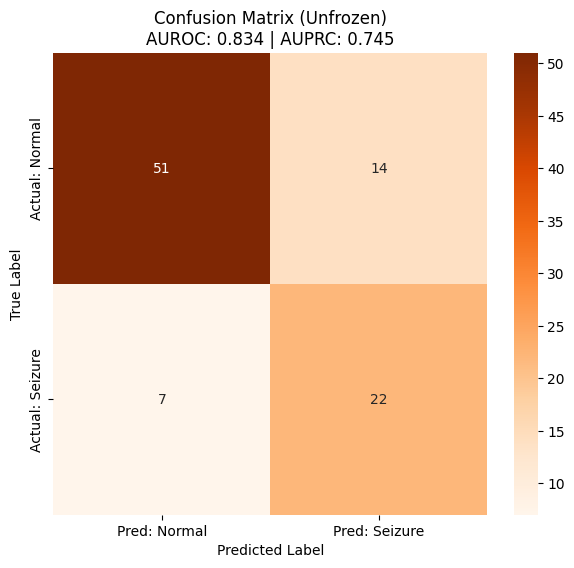

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

def test_unfrozen_performance(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = [] # Necessary for AUROC/AUPRC

    print("Evaluating Unfrozen Model (Full Fine-Tuning)...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # 1. Extract probabilities for the Seizure class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # 2. Get hard predictions (0 or 1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- CALCULATE SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    print(f"\n--- 🔥 UNFROZEN MODEL SCIENTIFIC RESULTS ---")
    print(f"✅ Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"📈 AUROC Score:      {auroc:.4f}")
    print(f"📊 AUPRC Score:      {auprc:.4f}")
    print("-" * 50)
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Seizure']))

    # --- PLOT CONFUSION MATRIX ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.title(f'Confusion Matrix (Unfrozen)\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run Evaluation
if 'model_unfrozen' in globals():
    test_unfrozen_performance(model_unfrozen, test_loader)
else:
    print("⚠️ 'trained_unfrozen_model' not found. Please run the unfrozen training cell first.")

In [25]:
import os
import torch
import torch.nn.functional as F
import scipy.io as sio
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def predict_new_files_unfrozen(model, search_path="/content"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model is None:
        print("⚠️ Model not found.")
        return
    model.eval()

    # Find test_1 files
    file_list = [os.path.join(r, f) for r, _, fs in os.walk(search_path)
                 for f in fs if f.startswith("test_1") and f.endswith(".mat")]

    if not file_list:
        print("No 'test_1' files found.")
        return

    print(f"\n🔎 Testing {len(file_list)} files with Unfrozen Model (Normalization + Converter B)...")
    print(f"{'FILENAME':<40} | {'PREDICTION':<12} | {'SEIZURE PROB'}")
    print("-" * 80)

    all_probs = []
    all_labels = []
    has_labels = False

    for fpath in file_list:
        try:
            mat = sio.loadmat(fpath)
            if 'data' not in mat: continue
            raw = mat['data'].astype(np.float32)

            # --- 1. NORMALIZATION (Required for Fine-Tuned Models) ---
            # Z-score: (x - mean) / std
            raw = (raw - np.mean(raw)) / (np.std(raw) + 1e-6)

            # --- 2. CONVERTER B (N_STACK=10) ---
            x = np.concatenate([raw[:, s::10] for s in range(10)], axis=0)
            x_tensor = torch.from_numpy(x).unsqueeze(0).unsqueeze(2).to(device)

            with torch.no_grad():
                outputs = model(x_tensor)
                probs = F.softmax(outputs, dim=1)

                # We track the specific probability of class 1 (Seizure)
                seizure_prob = probs[0, 1].item()
                conf, pred = torch.max(probs, 1)

                label = "Seizure ⚠️" if pred.item() == 1 else "Normal ✅"
                fname = os.path.basename(fpath)
                print(f"{fname[:38]:<40} | {label:<12} | {seizure_prob*100:.1f}%")

                # --- 3. COLLECT METRICS IF LABELS EXIST IN FILENAME ---
                fname_lower = fname.lower()
                if "ictal" in fname_lower or "interictal" in fname_lower:
                    true_label = 1.0 if "ictal" in fname_lower and "interictal" not in fname_lower else 0.0
                    all_labels.append(true_label)
                    all_probs.append(seizure_prob)
                    has_labels = True

        except Exception as e:
            print(f"Error processing {os.path.basename(fpath)}: {e}")

    # --- 4. BATCH SCIENTIFIC SUMMARY ---
    if has_labels and len(set(all_labels)) > 1:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
        print("-" * 80)
        print(f"📈 UNFROZEN BATCH METRICS (test_1 group):")
        print(f"Batch AUROC: {auroc:.4f}")
        print(f"Batch AUPRC: {auprc:.4f}")
        print("-" * 80)

# Run Inference
if 'model_unfrozen' in globals():
    predict_new_files_unfrozen(model_unfrozen)
else:
    print("⚠️ 'trained_unfrozen_model' not found. Please run the unfrozen training cell first.")


🔎 Testing 120 files with Unfrozen Model (Normalization + Converter B)...
FILENAME                                 | PREDICTION   | SEIZURE PROB
--------------------------------------------------------------------------------
test_1_i (16).mat                        | Seizure ⚠️   | 99.8%
test_1_ii (51).mat                       | Normal ✅     | 33.9%
test_1_i (25).mat                        | Seizure ⚠️   | 96.2%
test_1_ii (69).mat                       | Normal ✅     | 45.6%
test_1_ii (73).mat                       | Normal ✅     | 25.1%
test_1_ii (38).mat                       | Seizure ⚠️   | 53.9%
test_1_ii (39).mat                       | Seizure ⚠️   | 77.6%
test_1_ii (77).mat                       | Normal ✅     | 1.4%
test_1_i (12).mat                        | Seizure ⚠️   | 58.5%
test_1_i (24).mat                        | Seizure ⚠️   | 99.3%
test_1_ii (37).mat                       | Normal ✅     | 36.1%
test_1_ii (21).mat                       | Normal ✅     | 0.1%
test_1_i

converter a

In [26]:
import os
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_auc_score, average_precision_score
from torchvision import models

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 10
N_STACK = 10 # Downsampling factor for Converter A

# ==========================================
# 1. LOAD & CONVERT (Converter A Method)
# ==========================================
def load_converter_a_chronological(search_path="/content"):
    all_files = []
    for root, _, filenames in os.walk(search_path):
        for filename in filenames:
            if filename.endswith(".mat") and 'new_tests' not in root:
                all_files.append(os.path.join(root, filename))

    # [PAPER REQUIREMENT] Sort chronologically
    all_files.sort()

    processed_data = []
    labels = []

    print(f"Processing {len(all_files)} files using Converter A...")

    for fpath in all_files:
        fname = os.path.basename(fpath).lower()
        label = 0.0 if "interictal" in fname else 1.0 if "ictal" in fname else None
        if label is None: continue

        try:
            mat = sio.loadmat(fpath)
            raw_data = mat['data'].astype(np.float32)

            # Normalization
            raw_data = (raw_data - np.mean(raw_data)) / (np.std(raw_data) + 1e-6)

            # --- CONVERTER A LOGIC ---
            # Simply downsample by factor N_STACK (take every 10th sample)
            x = raw_data[:, ::N_STACK]

            processed_data.append(x)
            labels.append(label)
        except:
            continue

    # Converter A usually results in a single-channel-like stack
    X_tensor = torch.tensor(np.array(processed_data)).unsqueeze(1) # Add channel dim
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return X_tensor, y_tensor

X_all_A, y_all_A = load_converter_a_chronological()

# ==========================================
# 2. CHRONOLOGICAL 80/20 SPLIT
# ==========================================
interictal_idx = torch.where(y_all_A == 0)[0]
ictal_idx = torch.where(y_all_A == 1)[0]

split_inter = int(len(interictal_idx) * 0.8)
split_ictal = int(len(ictal_idx) * 0.8)

train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

X_train, y_train = X_all_A[train_indices], y_all_A[train_indices]
X_test, y_test = X_all_A[test_indices], y_all_A[test_indices]

# Weighted Sampler for Balance
train_labels = y_train.numpy()
weights = 1. / np.bincount(train_labels)
sampler = WeightedRandomSampler(torch.from_numpy(weights[train_labels]), len(train_labels))

train_loader_A = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, sampler=sampler)
test_loader_A = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Converter A Ready. Train: {len(X_train)}, Test: {len(X_test)}")

# ==========================================
# 3. MODEL & TRAINING (Converter A)
# ==========================================
model_A = models.shufflenet_v2_x0_5(weights=None)
# Adjust input for Converter A (usually 1 channel or based on sensor count)
model_A.conv1[0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model_A.fc = nn.Linear(model_A.fc.in_features, 2)
model_A.to(DEVICE)

optimizer = optim.Adam(model_A.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS):
    model_A.train()
    for inputs, labels in train_loader_A:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_A(inputs), labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model_A.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader_A:
            outputs = model_A(inputs.to(DEVICE))
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    print(f"Epoch {epoch+1} | AUROC: {roc_auc_score(all_labels, all_probs):.4f}")

Processing 586 files using Converter A...
✅ Converter A Ready. Train: 372, Test: 94
Epoch 1 | AUROC: 0.4727
Epoch 2 | AUROC: 0.4748
Epoch 3 | AUROC: 0.5188
Epoch 4 | AUROC: 0.4859
Epoch 5 | AUROC: 0.5788
Epoch 6 | AUROC: 0.5369
Epoch 7 | AUROC: 0.5613
Epoch 8 | AUROC: 0.5284
Epoch 9 | AUROC: 0.6695
Epoch 10 | AUROC: 0.6578


Evaluating Converter A Model (Downsampling Strategy)...

--- 🔥 CONVERTER A SCIENTIFIC RESULTS ---
✅ Overall Accuracy: 0.7340 (73.40%)
📈 AUROC Score:      0.6578
📊 AUPRC Score:      0.5176
--------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.76      0.89      0.82        65
     Seizure       0.61      0.38      0.47        29

    accuracy                           0.73        94
   macro avg       0.69      0.64      0.65        94
weighted avg       0.72      0.73      0.71        94



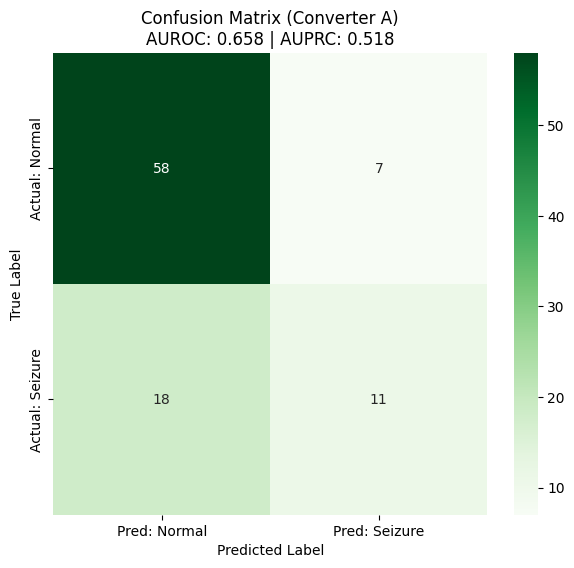

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

def test_converter_a_performance(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    print("Evaluating Converter A Model (Downsampling Strategy)...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # 1. Extract probabilities for the Seizure class (index 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # 2. Get hard predictions (0 or 1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- CALCULATE SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    print(f"\n--- 🔥 CONVERTER A SCIENTIFIC RESULTS ---")
    print(f"✅ Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"📈 AUROC Score:      {auroc:.4f}")
    print(f"📊 AUPRC Score:      {auprc:.4f}")
    print("-" * 50)
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Seizure']))

    # --- PLOT CONFUSION MATRIX ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.title(f'Confusion Matrix (Converter A)\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run Evaluation for Converter A
if 'model_A' in globals():
    test_converter_a_performance(model_A, test_loader_A)
else:
    print("⚠️ 'model_A' not found. Please run the Converter A training cell first.")

In [32]:
import os
import torch
import torch.nn.functional as F
import scipy.io as sio
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def predict_converter_a_new_files(model, search_path="/content"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model is None:
        print("⚠️ Converter A Model not found.")
        return
    model.eval()

    # Find files starting with 'test_1'
    file_list = [os.path.join(r, f) for r, _, fs in os.walk(search_path)
                 for f in fs if f.startswith("test_1") and f.endswith(".mat")]

    if not file_list:
        print("No 'test_1' files found in directory.")
        return

    print(f"\n🔎 Testing {len(file_list)} files with CONVERTER A (Normalization + Downsampling)...")
    print(f"{'FILENAME':<40} | {'PREDICTION':<12} | {'SEIZURE PROB'}")
    print("-" * 80)

    all_probs = []
    all_labels = []
    has_labels = False

    for fpath in file_list:
        try:
            mat = sio.loadmat(fpath)
            if 'data' not in mat: continue
            raw = mat['data'].astype(np.float32)

            # --- 1. Z-SCORE NORMALIZATION ---
            raw = (raw - np.mean(raw)) / (np.std(raw) + 1e-6)

            # --- 2. CONVERTER A LOGIC (N_STACK=10) ---
            # Simply downsample by factor of 10
            x = raw[:, ::10]

            # Add channel dimension (1) and batch dimension (unsqueeze)
            # Resulting shape: [1, 1, 16, 400] assuming 16 sensors and 400 samples
            x_tensor = torch.from_numpy(x).unsqueeze(0).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(x_tensor)
                probs = F.softmax(outputs, dim=1)

                seizure_prob = probs[0, 1].item()
                conf, pred = torch.max(probs, 1)

                label = "Seizure ⚠️" if pred.item() == 1 else "Normal ✅"
                fname = os.path.basename(fpath)
                print(f"{fname[:38]:<40} | {label:<12} | {seizure_prob*100:.1f}%")

                # --- 3. AUTO-EVALUATION ---
                fname_lower = fname.lower()
                if "ictal" in fname_lower or "interictal" in fname_lower:
                    true_label = 1.0 if "ictal" in fname_lower and "interictal" not in fname_lower else 0.0
                    all_labels.append(true_label)
                    all_probs.append(seizure_prob)
                    has_labels = True

        except Exception as e:
            print(f"Error in {os.path.basename(fpath)}: {e}")

    # --- 4. FINAL BATCH METRICS ---
    if has_labels and len(set(all_labels)) > 1:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
        print("-" * 80)
        print(f"📉 CONVERTER A BATCH SUMMARY:")
        print(f"Batch AUROC: {auroc:.4f}")
        print(f"Batch AUPRC: {auprc:.4f}")
        print("-" * 80)

# Run Inference
if 'model_A' in globals():
    predict_converter_a_new_files(model_A)
else:
    print("⚠️ 'model_A' not found. Please run the Converter A training cell first!")


🔎 Testing 120 files with CONVERTER A (Normalization + Downsampling)...
FILENAME                                 | PREDICTION   | SEIZURE PROB
--------------------------------------------------------------------------------
test_1_i (16).mat                        | Normal ✅     | 45.6%
test_1_ii (51).mat                       | Normal ✅     | 23.0%
test_1_i (25).mat                        | Normal ✅     | 25.2%
test_1_ii (69).mat                       | Seizure ⚠️   | 99.7%
test_1_ii (73).mat                       | Normal ✅     | 10.4%
test_1_ii (38).mat                       | Normal ✅     | 40.7%
test_1_ii (39).mat                       | Seizure ⚠️   | 82.9%
test_1_ii (77).mat                       | Normal ✅     | 28.2%
test_1_i (12).mat                        | Seizure ⚠️   | 87.7%
test_1_i (24).mat                        | Normal ✅     | 6.5%
test_1_ii (37).mat                       | Seizure ⚠️   | 95.4%
test_1_ii (21).mat                       | Normal ✅     | 15.5%
test_1_ii

scratch

In [27]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torchvision import models
from sklearn.metrics import roc_auc_score, average_precision_score

# --- CONFIGURATION ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

print(f"✅ Training Model FROM SCRATCH on: {DEVICE}")

# ==========================================
# 1. DATA PREPARATION (Chronological 80/20)
# ==========================================
if 'X_all' not in globals():
    print("⚠️ X_all not found. Please ensure the Converter B cell was run first.")
else:
    # [PAPER REQUIREMENT] Normalize data
    X_all_norm = (X_all - torch.mean(X_all)) / (torch.std(X_all) + 1e-6)

    # [PAPER REQUIREMENT] Chronological Stratified Split
    # We maintain the temporal sequence: 80% past data for training, 20% future data for testing.
    interictal_idx = torch.where(y_all == 0)[0]
    ictal_idx = torch.where(y_all == 1)[0]

    split_inter = int(len(interictal_idx) * 0.8)
    split_ictal = int(len(ictal_idx) * 0.8)

    train_indices = torch.cat([interictal_idx[:split_inter], ictal_idx[:split_ictal]])
    test_indices = torch.cat([interictal_idx[split_inter:], ictal_idx[split_ictal:]])

    X_train, y_train = X_all_norm[train_indices], y_all[train_indices]
    X_test, y_test = X_all_norm[test_indices], y_all[test_indices]

    # Weighted Sampler for class balance
    train_labels = y_train.numpy()
    weights = 1. / np.bincount(train_labels)
    sample_weights = weights[train_labels]
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights), len(sample_weights))

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, sampler=sampler)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

    print(f"✅ Data Ready (Chronological): Train={len(X_train)}, Test={len(X_test)}")

# ==========================================
# 2. MODEL SETUP (No Pretrained Weights)
# ==========================================
def build_scratch_model():
    print("Initializing ShuffleNet V2 (FROM SCRATCH - Random Weights)...")
    # weights=None ensures no pretraining from ImageNet is used
    model = models.shufflenet_v2_x0_5(weights=None)

    # 1. Adapt input for 160 channels (Converter B)
    model.conv1[0] = nn.Conv2d(160, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

    # 2. Update Classification Head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2)
    )

    # Ensure all layers are trainable
    for param in model.parameters():
        param.requires_grad = True

    return model.to(DEVICE)

model_scratch = build_scratch_model()

# ==========================================
# 3. OPTIMIZER & TRAINING
# ==========================================
optimizer = optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("\n--- Starting Training (Scratch Baseline) ---")
for epoch in range(NUM_EPOCHS):
    model_scratch.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model_scratch(inputs), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Evaluation
    model_scratch.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model_scratch(inputs)
            probs = F.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {epoch_loss/len(train_loader):.4f} | AUROC: {auroc:.4f} | AUPRC: {auprc:.4f}")

✅ Training Model FROM SCRATCH on: cuda
✅ Data Ready (Chronological): Train=372, Test=94
Initializing ShuffleNet V2 (FROM SCRATCH - Random Weights)...

--- Starting Training (Scratch Baseline) ---
Epoch 1/20 | Loss: 0.7872 | AUROC: 0.5066 | AUPRC: 0.3230
Epoch 2/20 | Loss: 0.6896 | AUROC: 0.4881 | AUPRC: 0.3240
Epoch 3/20 | Loss: 0.6918 | AUROC: 0.5066 | AUPRC: 0.3058
Epoch 4/20 | Loss: 0.6335 | AUROC: 0.5448 | AUPRC: 0.3328
Epoch 5/20 | Loss: 0.6252 | AUROC: 0.6186 | AUPRC: 0.4134
Epoch 6/20 | Loss: 0.6442 | AUROC: 0.6218 | AUPRC: 0.3699
Epoch 7/20 | Loss: 0.5828 | AUROC: 0.6239 | AUPRC: 0.4055
Epoch 8/20 | Loss: 0.6596 | AUROC: 0.5570 | AUPRC: 0.3396
Epoch 9/20 | Loss: 0.5892 | AUROC: 0.6058 | AUPRC: 0.3483
Epoch 10/20 | Loss: 0.4707 | AUROC: 0.6329 | AUPRC: 0.3930
Epoch 11/20 | Loss: 0.5674 | AUROC: 0.6653 | AUPRC: 0.4724
Epoch 12/20 | Loss: 0.5310 | AUROC: 0.5936 | AUPRC: 0.3815
Epoch 13/20 | Loss: 0.5487 | AUROC: 0.5836 | AUPRC: 0.4094
Epoch 14/20 | Loss: 0.4974 | AUROC: 0.6249 | A

Evaluating Model Trained from Scratch...

--- 🧊 LEARNING FROM SCRATCH RESULTS ---
✅ Overall Accuracy: 0.5957 (59.57%)
📈 AUROC Score:      0.5220
📊 AUPRC Score:      0.4632
--------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.71      0.71      0.71        65
     Seizure       0.34      0.34      0.34        29

    accuracy                           0.60        94
   macro avg       0.53      0.53      0.53        94
weighted avg       0.60      0.60      0.60        94



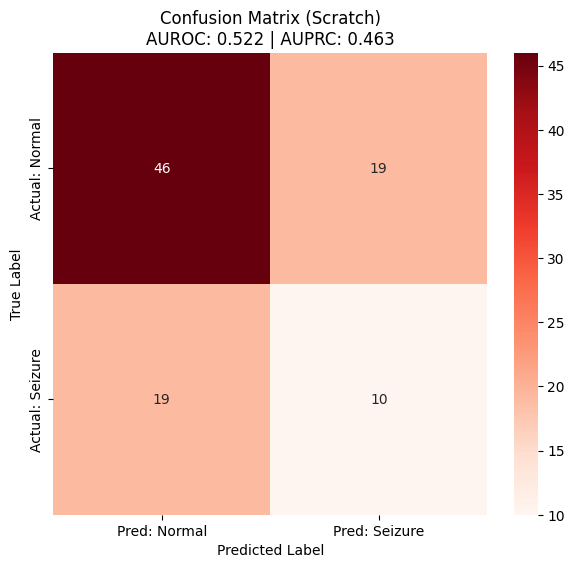

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, average_precision_score)

def test_scratch_model(model, test_loader):
    """
    Evaluates the Scratch model with AUROC and AUPRC metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = [] # To store seizure probabilities for scientific metrics

    print("Evaluating Model Trained from Scratch...")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # 1. Get seizure probabilities (Class 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            # 2. Get discrete predictions
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- SCIENTIFIC METRICS ---
    accuracy = accuracy_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)

    report = classification_report(all_labels, all_preds,
                                   target_names=['Normal', 'Seizure'])
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n--- 🧊 LEARNING FROM SCRATCH RESULTS ---")
    print(f"✅ Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"📈 AUROC Score:      {auroc:.4f}")
    print(f"📊 AUPRC Score:      {auprc:.4f}")
    print("-" * 50)
    print(report)

    # --- VISUALIZATION ---
    # AUROC helps visualize the trade-off between sensitivity and specificity


    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=['Pred: Normal', 'Pred: Seizure'],
                yticklabels=['Actual: Normal', 'Actual: Seizure'])
    plt.title(f'Confusion Matrix (Scratch)\nAUROC: {auroc:.3f} | AUPRC: {auprc:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run the test
if 'model_scratch' in globals():
    test_scratch_model(model_scratch, test_loader)
else:
    print("⚠️ 'trained_scratch_model' not found. Run the scratch training cell first!")

In [30]:
import os
import torch
import torch.nn.functional as F
import scipy.io as sio
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def predict_scratch_new_files(model, search_path="/content"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if model is None:
        print("⚠️ Model not found.")
        return
    model.eval()

    # Find files starting with 'test_1'
    file_list = [os.path.join(r, f) for r, _, fs in os.walk(search_path)
                 for f in fs if f.startswith("test_1") and f.endswith(".mat")]

    if not file_list:
        print("No 'test_1' files found in directory.")
        return

    print(f"\n🔎 Testing {len(file_list)} files with Scratch Model (Normalization + Converter B)...")
    print(f"{'FILENAME':<40} | {'PREDICTION':<12} | {'SEIZURE PROB'}")
    print("-" * 80)

    all_probs = []
    all_labels = []
    has_labels = False

    for fpath in file_list:
        try:
            mat = sio.loadmat(fpath)
            if 'data' not in mat: continue
            raw = mat['data'].astype(np.float32)

            # --- 1. Z-SCORE NORMALIZATION ---
            # Essential for models trained from scratch to maintain numerical stability
            raw = (raw - np.mean(raw)) / (np.std(raw) + 1e-6)

            # --- 2. CONVERTER B (N_STACK=10) ---
            x = np.concatenate([raw[:, s::10] for s in range(10)], axis=0)
            x_tensor = torch.from_numpy(x).unsqueeze(0).unsqueeze(2).to(device)

            with torch.no_grad():
                outputs = model(x_tensor)
                probs = F.softmax(outputs, dim=1)

                # Specifically extract the probability of the seizure class
                seizure_prob = probs[0, 1].item()
                conf, pred = torch.max(probs, 1)

                label = "Seizure ⚠️" if pred.item() == 1 else "Normal ✅"
                fname = os.path.basename(fpath)
                print(f"{fname[:38]:<40} | {label:<12} | {seizure_prob*100:.1f}%")

                # --- 3. AUTO-EVALUATION (If labels exist in filename) ---
                fname_lower = fname.lower()
                if "ictal" in fname_lower or "interictal" in fname_lower:
                    true_label = 1.0 if "ictal" in fname_lower and "interictal" not in fname_lower else 0.0
                    all_labels.append(true_label)
                    all_probs.append(seizure_prob)
                    has_labels = True

        except Exception as e:
            print(f"Error in {os.path.basename(fpath)}: {e}")

    # --- 4. FINAL BATCH METRICS ---
    if has_labels and len(set(all_labels)) > 1:
        auroc = roc_auc_score(all_labels, all_probs)
        auprc = average_precision_score(all_labels, all_probs)
        print("-" * 80)
        print(f"📉 SCRATCH MODEL BATCH SUMMARY:")
        print(f"Batch AUROC: {auroc:.4f}")
        print(f"Batch AUPRC: {auprc:.4f}")
        print("-" * 80)

# Run Inference
if 'model_scratch' in globals():
    predict_scratch_new_files(model_scratch)
else:
    print("⚠️ 'trained_scratch_model' not found. Please run the scratch training cell first!")


🔎 Testing 120 files with Scratch Model (Normalization + Converter B)...
FILENAME                                 | PREDICTION   | SEIZURE PROB
--------------------------------------------------------------------------------
test_1_i (16).mat                        | Seizure ⚠️   | 59.3%
test_1_ii (51).mat                       | Normal ✅     | 5.3%
test_1_i (25).mat                        | Normal ✅     | 10.6%
test_1_ii (69).mat                       | Seizure ⚠️   | 88.6%
test_1_ii (73).mat                       | Normal ✅     | 3.8%
test_1_ii (38).mat                       | Normal ✅     | 28.5%
test_1_ii (39).mat                       | Normal ✅     | 26.1%
test_1_ii (77).mat                       | Normal ✅     | 6.5%
test_1_i (12).mat                        | Seizure ⚠️   | 90.9%
test_1_i (24).mat                        | Normal ✅     | 49.3%
test_1_ii (37).mat                       | Seizure ⚠️   | 87.6%
test_1_ii (21).mat                       | Normal ✅     | 4.2%
test_1_ii (